In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from syd import make_viewer

from src.iaf.experiments import get_experiment

base_dp_ratio = 1.1
distal_dp_ratio = 1.05
no_distal = False
config = "hofer"
num_simulations = 3
sim, cfg = get_experiment(
    config,
    base_dp_ratio=base_dp_ratio,
    distal_dp_ratio=distal_dp_ratio,
    no_distal=no_distal,
    num_simulations=num_simulations,
    edge_probability=0.75,
    independent_noise_rate=0.1,
)

# No inhibition (at all!)
# Reducing concentration back a bit
# Reduced synaptic weights for all groups

# Just reduced distal weight from 40 to 20

# -- this one looks good, let's do a run of this with all the parameters! --

In [2]:
do_sim = True
if do_sim:
    results = sim.run(duration=2400, initialize=True)

  2%|▏         | 40/2400 [00:29<28:35,  1.38it/s] 


KeyboardInterrupt: 

In [4]:
def make_psth(spike_times, duration, dt):
    psth = np.zeros((duration * int(1/dt)))
    psth[spike_times] = 1
    psth = np.sum(np.reshape(psth, (duration, -1)), axis=1)
    return psth

In [14]:
duration = results["weights"][0]["proximal"].shape[0]
dt = cfg.dt

psths = np.stack([make_psth(st, duration, dt) for st in results["spike_times"]], axis=0)
basal_weights = np.stack([np.mean(w["proximal"][-100:], axis=0) for w in results["weights"]], axis=0)
simple_weights = np.stack([np.mean(w["distal-simple"][-100:], axis=0) for w in results["weights"]], axis=0)
complex_weights = np.stack([np.mean(w["distal-complex"][-100:], axis=0) for w in results["weights"]], axis=0)

basal_weights = basal_weights / cfg.synapses["proximal"].max_weight / cfg.synapses["proximal"].num_synapses * 4
simple_weights = simple_weights / cfg.synapses["distal-simple"].max_weight / cfg.synapses["distal-simple"].num_synapses * 20
complex_weights = complex_weights / cfg.synapses["distal-complex"].max_weight / cfg.synapses["distal-complex"].num_synapses * 20

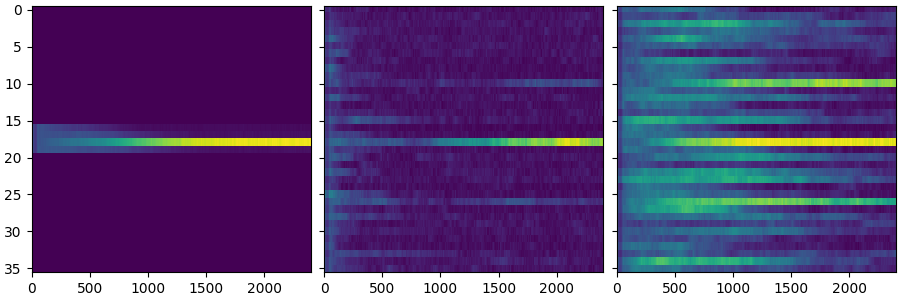

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained", sharex=True, sharey=True)
ax[0].imshow(results["weights"][0]["proximal"].T, aspect="auto", interpolation="none")
ax[1].imshow(results["weights"][0]["distal-simple"].T, aspect="auto", interpolation="none")
ax[2].imshow(results["weights"][0]["distal-complex"].T, aspect="auto", interpolation="none")
plt.show()

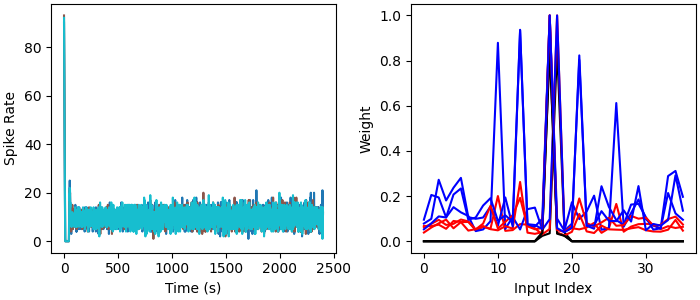

In [16]:
cmap = plt.get_cmap("tab10")
colors = cmap(np.linspace(0, 1, psths.shape[0]))

fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout="constrained")
for ineuron in range(psths.shape[0]):
    ax[0].plot(psths[ineuron], color=colors[ineuron])
    ax[1].plot(basal_weights[ineuron], color="k")
    ax[1].plot(simple_weights[ineuron] / np.max(simple_weights[ineuron]), color="r")
    ax[1].plot(complex_weights[ineuron] / np.max(complex_weights[ineuron]), color="b")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Spike Rate")
ax[1].set_xlabel("Input Index")
ax[1].set_ylabel("Weight")
plt.show()

In [17]:
from src.iaf.plotting import create_gabor, stitch_gabor_grid

def weights_to_gabor(weights, orientations, spacing=2, **params):
    weights = weights.T.reshape(9, 4)
    gabors = [[None for _ in range(weights.shape[1])] for _ in range(weights.shape[0])]
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            gabor = weights[i, j] * create_gabor(orientation=orientations[j], **params)
            gabors[i][j] = gabor
        gabors[i] = np.sum(np.stack(gabors[i]), axis=0)
    gwidth = gabors[0].shape[0]
    gabors = np.stack(gabors).reshape(3, 3, gwidth, gwidth)
    return stitch_gabor_grid(gabors, spacing=spacing)

In [6]:
gabor = sim.source_populations["excitatory"]

def plot(state):
    ineuron = state["neuron"]
    spacing = state["spacing"]
    vmax = state["vmax"]

    basal_gabor = weights_to_gabor(basal_weights[ineuron], gabor.orientations, spacing=spacing)
    simple_gabor = weights_to_gabor(simple_weights[ineuron], gabor.orientations, spacing=spacing)
    complex_gabor = weights_to_gabor(complex_weights[ineuron], gabor.orientations, spacing=spacing)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
    ax[0].imshow(basal_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[0].set_title(f"{np.max(basal_gabor)}")
    ax[1].imshow(simple_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[1].set_title(f"{np.max(simple_gabor)}")
    ax[2].imshow(complex_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[2].set_title(f"{np.max(complex_gabor)}")
    return fig

viewer = make_viewer(plot)
viewer.add_integer("neuron", value=0, min=0, max=psths.shape[0] - 1)
viewer.add_integer("spacing", value=3, min=0, max=10)
viewer.add_float("vmax", value=0.5, min=0.0, max=1.0)
viewer.show()

NameError: name 'psths' is not defined

In [2]:
gabor = sim.source_populations["excitatory"]

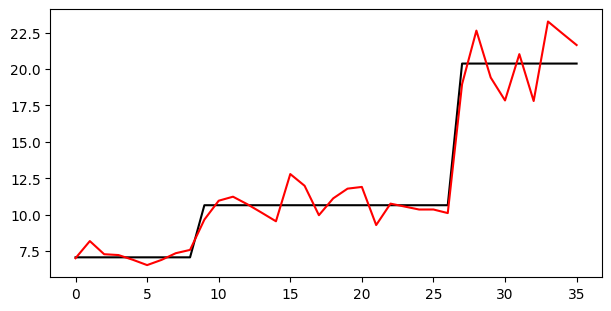

In [22]:
rates = sorted(gabor.generate_rates()[0])

independent_noise = 0.1
new_rates = rates + np.random.randn(len(rates)) * rates * independent_noise

plt.show()
fig, ax = plt.subplots(1, 1, figsize=(6, 3), layout="constrained")
ax.plot(rates, c="k")
ax.plot(new_rates, c="r")
plt.show()


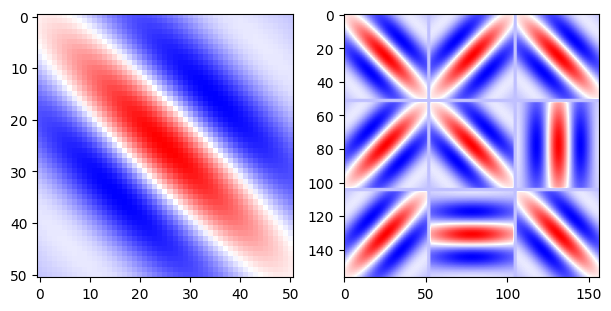

In [6]:
from src.iaf.plotting import create_gabor, create_gabor_grid

params = dict(
    width=0.6,
    envelope=0.4,
    gamma=1.5,
    halfsize=25,
    phase=0,
)
stim = gabor.generate_stimulus(edge_probability=1.1)
stimori = gabor.orientations[stim]
single = create_gabor(orientation=stimori[1, 1], **params)
# ssss = get_gabor(sigma=25, theta=stimori[1, 1], Lambda=28, psi=0, gamma=0.5)
grid = create_gabor_grid(stimori, spacing=2, gabor_params=params)[0]
fig, ax = plt.subplots(1, 2, figsize=(6, 3), layout="constrained")
ax[0].imshow(single, aspect="auto", cmap="bwr")
ax[1].imshow(grid, aspect="auto", cmap="bwr")
plt.show()

In [75]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from src.utils import rng
from src.iaf.plotting import create_gabor, create_gabor_grid
from src.iaf.synapse_group import SpikeGenerator
gabor = sim.source_populations["excitatory"]
gabor.concentration = 1.5
gabor.edge_probability = 0.5
gabor.baseline_rate = 15.0
gabor.driven_rate = 30.0
spikegen = SpikeGenerator(num_neurons=gabor.num_inputs, dt=sim.dt)

T = 2000
tau = 5
def get_input(T):
    stims = []
    orientations = []
    rates = []
    spikes = []
    tau_interval = tau
    next_change = 0
    num_changes = 0
    for _ in range(T):
        if next_change == 0:
            next_change = int(rng.exponential(tau_interval) + 1)
            num_changes += 1
            stim = gabor.generate_stimulus()
            orientation = gabor.orientations[stim]
            rate = gabor.convert_stimulus_to_rates(stim)
        next_change -= 1
        spike = spikegen.get_spikes(rate.reshape(-1))
        stims.append(stim)
        orientations.append(orientation)
        rates.append(rate)
        spikes.append(spike)
    print("Num changes:", num_changes)
    return np.stack(stims), np.stack(orientations), np.stack(rates), np.stack(spikes)

stims, orientations, rates, spikes = get_input(T)
print(np.mean(rates))
smooth_spikes = savgol_filter(spikes, window_length=tau, polyorder=1, axis=0)
rate_corrs = np.corrcoef(np.reshape(rates, (T, -1)).T)
spike_corrs = np.corrcoef(np.reshape(smooth_spikes, (T, -1)).T)
print(stims.shape, orientations.shape, rates.shape, spikes.shape, rate_corrs.shape, spike_corrs.shape)

def plot(state):
    itime = state["itime"]
    vmax = state["spksvmax"]
    fig, ax = plt.subplots(1, 4, figsize=(10, 3), layout="constrained")
    grid = create_gabor_grid(orientations[itime], spacing=2)[0]
    max_grid = np.nanmax(np.abs(grid))
    ax[0].imshow(grid, aspect="auto", cmap="bwr", vmin=-max_grid, vmax=max_grid)
    ax[1].imshow(rates[itime].reshape(-1, 1), aspect="auto", cmap="bwr")
    ax[2].imshow(rate_corrs, aspect="auto", cmap="bwr", vmin=-1, vmax=1)
    ax[3].imshow(spike_corrs, aspect="auto", cmap="bwr", vmin=-vmax, vmax=vmax)
    return fig

viewer = make_viewer(plot)
viewer.add_integer("itime", min=0, max=T-1)
viewer.add_float("spksvmax", value=0.1, min=0.01, max=1.0)
viewer.show()

Num changes: 350
19.86012978545909
(2000, 3, 3) (2000, 3, 3) (2000, 9, 4) (2000, 36) (36, 36) (36, 36)


ParameterAddError: Failed to create integer parameter 'itime': Viewer.add_integer() got an unexpected keyword argument 'min'